In [2]:

import numpy as np
import cv2
import yaml
import matplotlib.pyplot as plt
import os
import time

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
data_path = "/mnt/ldata/data/spi/spi/rs435_2025-07-23-09-10-02_sb_lab_picking/postproc/rs435_2025-07-23-09-10-02_segment_1/"
time_path = data_path + "times.txt"
traj_path = data_path + "CameraTrajectory.txt"

traj = np.loadtxt(traj_path, delimiter=" ")
traj = traj.reshape(-1, 3, 4)

# append 0 0 0 1 to each 3x4 matrix
append_row = np.zeros((traj.shape[0], 1, 4))
append_row[:, 0, 3] = 1
traj = np.concatenate((traj, append_row), axis=1)

timestamps = np.loadtxt(time_path, delimiter=" ")

print(traj.shape)
print(timestamps.shape)

(125, 4, 4)
(125,)


In [4]:
# Install scipy if not available
try:
    from scipy.spatial.transform import Rotation
    print("scipy is already available")
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scipy"])
    from scipy.spatial.transform import Rotation
    print("scipy installed successfully")

scipy is already available


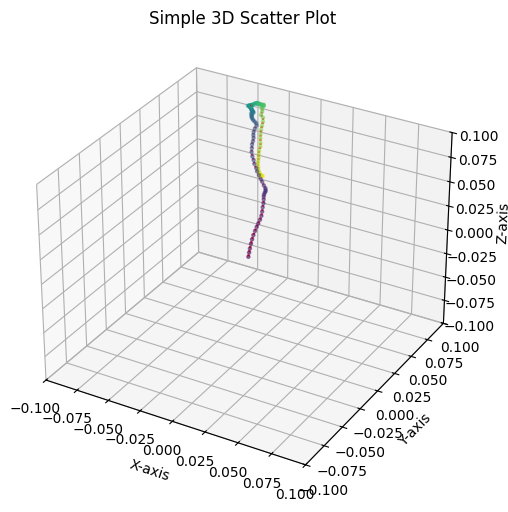

In [5]:
# 2. Create a figure and a 3D axes object
fig = plt.figure(figsize=(8, 6)) # Adjust figure size as needed
ax = fig.add_subplot(111, projection='3d') # '111' means 1 row, 1 column, first subplot
# 3. Plot the trajectory in 3D
traj_use = traj[:]
ax.scatter(traj_use[:, 0, 3], traj_use[:, 1, 3], traj_use[:, 2, 3], s=5, c=np.arange(len(traj_use)), cmap='viridis', alpha=0.5)    

# Add arrows showing direction from each point to the next
for i in range(len(traj_use) - 1):
    # Current point
    x, y, z = traj_use[i, 0, 3], traj_use[i, 1, 3], traj_use[i, 2, 3]
    # Direction vector to next point
    dx = traj_use[i+1, 0, 3] - x
    dy = traj_use[i+1, 1, 3] - y
    dz = traj_use[i+1, 2, 3] - z
    # Add arrow
    ax.quiver(x, y, z, dx, dy, dz, color='red', alpha=0.6, arrow_length_ratio=0.5, length=0.5)

# 4. Set labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Simple 3D Scatter Plot')
ax.set_xlim([-0.1, 0.1])  # Adjust limits as needed
ax.set_ylim([-0.1, 0.1])  # Adjust limits as needed
ax.set_zlim([-0.1, 0.1])  # Adjust limits as needed

# 5. Display the plot
plt.show()

In [6]:
# Transform trajectory to initial camera frame with X-forward coordinate system
# Step 1: Get the initial camera pose as reference frame
T_world_to_initial_cam = traj[0]  # First pose becomes our reference
T_initial_cam_to_world = np.linalg.inv(T_world_to_initial_cam)

print("Initial camera pose (world to camera):")
print(T_world_to_initial_cam)
print()

# Step 2: Transformation from ORB-SLAM camera frame to X-forward frame
# ORB-SLAM: X-right, Y-down, Z-forward
# init_cam:   X-forward, Y-left, Z-up

T_init_cam_to_orb = np.array([
    [ 0, 0, 1, 0],  # Target X = ORB Z (forward)
    [-1, 0, 0, 0],  # Target Y = -ORB X (right -> left)
    [ 0,-1, 0, 0],  # Target Z = -ORB Y (down -> up)
    [ 0, 0, 0, 1]
])
print("Transformation matrix T_init_cam_to_orb:")
print(T_init_cam_to_orb)
print()

# Step 3: Transform all poses to be relative to initial camera frame with new coordinate system
traj_ee_link = np.zeros_like(traj)

for i in range(len(traj)):
    # Current pose in world coordinates (ORB-SLAM frame)
    T_orb_to_traj = traj[i]
    
    # Transform to be relative to initial camera frame (still in ORB coordinates)
    T_init_cam_to_traj = T_init_cam_to_orb @ T_orb_to_traj
    
    # Extract position and rotation
    position_orb = T_init_cam_to_traj[:3, 3]
    rotation_orb = T_init_cam_to_traj[:3, :3]
    
    traj_ee_link[i] = T_init_cam_to_traj

print(f"Original trajectory shape: {traj.shape}")
print(f"Target frame trajectory shape: {traj_ee_link.shape}")
print()
print("First few positions in world coordinates (ORB-SLAM frame):")
print(traj[:3, :3, 3])
print()
print("First few positions relative to initial camera (X-forward frame):")
print(traj_ee_link[:3, :3, 3])
print()


Initial camera pose (world to camera):
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

Transformation matrix T_init_cam_to_orb:
[[ 0  0  1  0]
 [-1  0  0  0]
 [ 0 -1  0  0]
 [ 0  0  0  1]]

Original trajectory shape: (125, 4, 4)
Target frame trajectory shape: (125, 4, 4)

First few positions in world coordinates (ORB-SLAM frame):
[[0.         0.         0.        ]
 [0.00014629 0.00072166 0.00395026]
 [0.00049834 0.00119    0.00797248]]

First few positions relative to initial camera (X-forward frame):
[[ 0.          0.          0.        ]
 [ 0.00395026 -0.00014629 -0.00072166]
 [ 0.00797248 -0.00049834 -0.00119   ]]



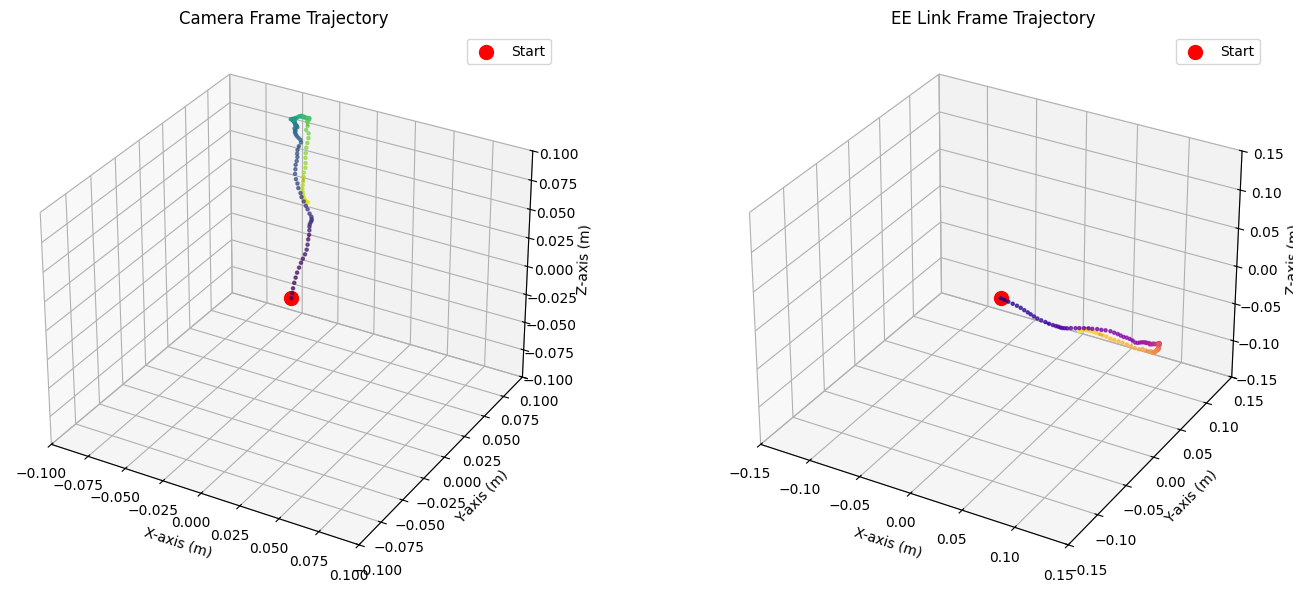

Trajectory Statistics:
Cam link frame - Position range:
  X: [0.000, 0.154]
  Y: [-0.010, 0.000]
  Z: [-0.010, 0.003]


In [ ]:
# Visualize both trajectories for comparison
fig = plt.figure(figsize=(15, 6))

# Plot 1: Camera frame trajectory
ax1 = fig.add_subplot(121, projection='3d')
traj_use = traj[:]
ax1.scatter(traj_use[:, 0, 3], traj_use[:, 1, 3], traj_use[:, 2, 3], 
           s=5, c=np.arange(len(traj_use)), cmap='viridis', alpha=0.7)

# Add red marker at initial point
ax1.scatter(traj_use[0, 0, 3], traj_use[0, 1, 3], traj_use[0, 2, 3], 
           s=100, c='red', marker='o', alpha=1.0, label='Start')

# Add some arrows for direction
step = max(1, len(traj_use) // 10)  # Show every 10th arrow
for i in range(0, len(traj_use) - 1, step):
    x, y, z = traj_use[i, 0, 3], traj_use[i, 1, 3], traj_use[i, 2, 3]
    dx = traj_use[i+1, 0, 3] - x
    dy = traj_use[i+1, 1, 3] - y
    dz = traj_use[i+1, 2, 3] - z
    ax1.quiver(x, y, z, dx, dy, dz, color='red', alpha=0.6, arrow_length_ratio=0.3)

ax1.set_xlabel('X-axis (m)')
ax1.set_ylabel('Y-axis (m)')
ax1.set_zlabel('Z-axis (m)')
ax1.set_xlim([-0.1, 0.1])  # Adjust limits as needed
ax1.set_ylim([-0.1, 0.1])  # Adjust limits as needed
ax1.set_zlim([-0.1, 0.1])  # Adjust limits as needed
ax1.legend()

# Plot 2: EE link frame trajectory
ax2 = fig.add_subplot(122, projection='3d')
traj_ee_use = traj_ee_link[:]
ax2.scatter(traj_ee_use[:, 0, 3], traj_ee_use[:, 1, 3], traj_ee_use[:, 2, 3], 
           s=5, c=np.arange(len(traj_ee_use)), cmap='plasma', alpha=0.7)

# Add red marker at initial point
ax2.scatter(traj_ee_use[0, 0, 3], traj_ee_use[0, 1, 3], traj_ee_use[0, 2, 3], 
           s=100, c='red', marker='o', alpha=1.0, label='Start')

# Add some arrows for direction
for i in range(0, len(traj_ee_use) - 1, step):
    x, y, z = traj_ee_use[i, 0, 3], traj_ee_use[i, 1, 3], traj_ee_use[i, 2, 3]
    dx = traj_ee_use[i+1, 0, 3] - x
    dy = traj_ee_use[i+1, 1, 3] - y
    dz = traj_ee_use[i+1, 2, 3] - z
    ax2.quiver(x, y, z, dx, dy, dz, color='blue', alpha=0.6, arrow_length_ratio=0.3)

ax2.set_xlabel('X-axis (m)')
ax2.set_ylabel('Y-axis (m)')
ax2.set_zlabel('Z-axis (m)')
ax2.set_title('EE Link Frame Trajectory')
ax2.set_xlim([-0.15, 0.15])  # Adjust limits as needed
ax2.set_ylim([-0.15, 0.15])  # Adjust limits as needed
ax2.set_zlim([-0.15, 0.15])  # Adjust limits as needed
ax2.legend()
plt.tight_layout()
plt.show()

# Print some statistics
print("Trajectory Statistics:")
print(f"Camera frame - Position range:")
print(f"  X: [{traj[:, 0, 3].min():.3f}, {traj[:, 0, 3].max():.3f}]")
print(f"  Y: [{traj[:, 1, 3].min():.3f}, {traj[:, 1, 3].max():.3f}]") 
print(f"  Z: [{traj[:, 2, 3].min():.3f}, {traj[:, 2, 3].max():.3f}]")
print()
print(f"EE link frame - Position range:")
print(f"  X: [{traj_ee_link[:, 0, 3].min():.3f}, {traj_ee_link[:, 0, 3].max():.3f}]")
print(f"  Y: [{traj_ee_link[:, 1, 3].min():.3f}, {traj_ee_link[:, 1, 3].max():.3f}]")
print(f"  Z: [{traj_ee_link[:, 2, 3].min():.3f}, {traj_ee_link[:, 2, 3].max():.3f}]")